In [1]:
from __future__ import print_function
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80
plt.style.use('seaborn-pastel')

import os
import sys
import codecs
import re
import numpy as np

In [2]:
#parameters for the Model
parameters = OrderedDict()
parameters['train'] = "./data/vta/train/" #Path to train file
parameters['dev'] = "./data/vta/valid/" #Path to test file
parameters['test'] = "./data/eng.testb" #Path to dev file
parameters['tag_scheme'] = "BIOES" #BIO or BIOES
parameters['lower'] = True # Boolean variable to control lowercasing of words
parameters['zeros'] =  True # Boolean variable to control replacement of  all digits by 0 
parameters['char_dim'] = 30 #Char embedding dimension
parameters['word_dim'] = 100 #Token embedding dimension
parameters['hidden_dim'] = 200 #Token LSTM hidden layer size
parameters['normalize_inputs']=True
parameters['word_bidirect'] = True #Use a bidirectional LSTM for words
parameters['embedding_path'] = "./data/glove.6B.100d.txt" #Location of pretrained embeddings
parameters['all_emb'] = 1 #Load all embeddings
parameters['crf'] =1 #Use CRF (0 to disable)
parameters['dropout'] = 0.5 #Droupout on the input (0 = no dropout)
parameters['epoch'] =  50 #Number of epochs to run"
parameters['weights'] = "" #path to Pretrained for from a previous run
parameters['name'] = "vta_re_try" # Model name
parameters['gradient_clip']=5.0
parameters['char_mode']="CNN"
models_path = "./models/" #path to saved models

#GPU
parameters['use_gpu'] = torch.cuda.is_available() #GPU Check
use_gpu = parameters['use_gpu']

parameters['reload'] = "./models/pre-trained-model" 

#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

In [3]:
#paths to files 
#To stored mapping file
mapping_file = './data/mapping.pkl'

#To stored model
name = parameters['name']
model_name = models_path + name #get_name(parameters)

if not os.path.exists(models_path):
    os.makedirs(models_path)

In [4]:
def load_network_samples(path):
    """
    Load sentences. A line must contain at least a word and its tag.
    Sentences are separated by empty lines.
    """
    files = [pos_txt for pos_txt in os.listdir(path) if pos_txt.endswith('.txt')]
    
    networks = []
    network = []
    
    for file in files:
        network = []
        with open(os.path.join(path, file), 'r') as myfile:
            for line in myfile.readlines():
                sample = line.rstrip().split('\t')
                if len(sample) == 11:
                    #network.append([float(data) for data in sample[:-1]])
                    #network[-1].append(sample[-1])
                    network.append(sample)
            
            networks.append(network)
    return networks

In [5]:
train_networks = load_network_samples(parameters['train'])
valid_networks = load_network_samples(parameters['dev'])

In [6]:
all_networks = train_networks+valid_networks

In [7]:
len(all_networks)

30

In [8]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def tag_mapping(networks, valid_networks=None):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[sample[-1] for sample in network] for network in networks]
    if valid_networks is not None:
        tags.append([sample[-1] for sample in network] for network in valid_networks)
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag

In [9]:
dico_tags, tag_to_id, id_to_tag = tag_mapping(all_networks)

Found 37 unique named entity tags


In [10]:
dico_tags

{'B-CR': 60,
 'L-CR': 986,
 'E-CR': 55,
 'N-CR': 73,
 'B-CBR': 37,
 'L-CBR': 545,
 'E-CBR': 39,
 'BE-CR': 6,
 'B-P': 23,
 'E-P': 20,
 'N-P': 43,
 'BE-CBR': 9,
 'N-CBR': 77,
 'L-P': 141,
 'EB-CBR': 23,
 'B-CB': 13,
 'L-CB': 115,
 'E-CB': 20,
 'N-CB': 17,
 'EB-CB': 11,
 'BE-P': 9,
 'EB-P': 5,
 'EB-CR': 21,
 'B-C': 13,
 'L-C': 99,
 'E-C': 15,
 'N-C': 21,
 'B-M': 9,
 'L-M': 18,
 'E-M': 6,
 'BE-M': 9,
 'EB-C': 4,
 'BE-CB': 4,
 'N-M': 3,
 'EB-M': 1,
 '<START>': -1,
 '<STOP>': -2}

In [11]:
def prepare_dataset(networks, tag_to_id):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for network in networks:
        tags = [tag_to_id[sample[-1]] for sample in network]
        readings = []
        for sample in network:
            readings.append([float(reading) for reading in sample[:-1]])
        
        data.append({
            'readings': readings,
            'tags': tags,
        })
    return data

train_data = prepare_dataset(
    train_networks, tag_to_id
)
dev_data = prepare_dataset(
    valid_networks, tag_to_id
)

print("{} / {} networks in train / dev .".format(len(train_data), len(dev_data)))

24 / 6 networks in train / dev .


In [12]:
train_data[0]["readings"][0]

[203904.0, 32.594, 25088.0, 4.01, 4368.0, 0.698, 800.0, 0.128, 256.0, 0.041]

In [13]:
def init_linear(input_linear):
    """
    Initialize linear transformation
    """
    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform(input_linear.weight, -bias, bias)
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()

In [14]:
def init_lstm(input_lstm):
    """
    Initialize lstm
    
    PyTorch weights parameters:
    
        weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
            of shape `(hidden_size * input_size)` for `k = 0`. Otherwise, the shape is
            `(hidden_size * hidden_size)`
            
        weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
            of shape `(hidden_size * hidden_size)`            
    """
    
    # Weights init for forward layer
    for ind in range(0, input_lstm.num_layers):
        
        ## Gets the weights Tensor from our model, for the input-hidden weights in our current layer
        weight = eval('input_lstm.weight_ih_l' + str(ind))
        
        # Initialize the sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        
        # Randomly sample from our samping range using uniform distribution and apply it to our current layer
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        # Similar to above but for the hidden-hidden weights of the current layer
        weight = eval('input_lstm.weight_hh_l' + str(ind))
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        
    # We do the above again, for the backward layer if we are using a bi-directional LSTM (our final model uses this)
    if input_lstm.bidirectional:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)
            weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)

    # Bias initialization steps
    
    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind))
            
            # Initializing to zero
            bias.data.zero_()
            
            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            #Similar for the hidden-hidden layer
            bias = eval('input_lstm.bias_hh_l' + str(ind))
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
        # Similar to above, we do for backward layer if we are using a bi-directional LSTM 
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                bias = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                bias = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

In [15]:
def log_sum_exp(vec):
    '''
    This function calculates the score explained above for the forward algorithm
    vec 2D: 1 * tagset_size
    '''
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
def argmax(vec):
    '''
    This function returns the max index in a vector
    '''
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def to_scalar(var):
    '''
    Function to convert pytorch tensor to a scalar
    '''
    return var.view(-1).data.tolist()[0]

In [16]:
def score_network(self, feats, tags):
    # tags is ground_truth, a list of ints, length is len(sentence)
    # feats is a 2D tensor, len(sentence) * tagset_size
    r = torch.LongTensor(range(feats.size()[0]))
    if self.use_gpu:
        r = r.cuda()
        pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])
    else:
        pad_start_tags = torch.cat([torch.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.LongTensor([self.tag_to_ix[STOP_TAG]])])

    score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(feats[r, tags])

    return score

In [17]:
def forward_alg(self, feats):
    '''
    This function performs the forward algorithm explained above
    '''
    # calculate in log domain
    # feats is len(sentence) * tagset_size
    # initialize alpha with a Tensor with values all equal to -10000.
    
    # Do the forward algorithm to compute the partition function
    init_alphas = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    
    # START_TAG has all of the score.
    init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
    
    # Wrap in a variable so that we will get automatic backprop
    forward_var = autograd.Variable(init_alphas)
    if self.use_gpu:
        forward_var = forward_var.cuda()
        
    # Iterate through the sentence
    for feat in feats:
        # broadcast the emission score: it is the same regardless of
        # the previous tag
        emit_score = feat.view(-1, 1)
        
        # the ith entry of trans_score is the score of transitioning to
        # next_tag from i
        tag_var = forward_var + self.transitions + emit_score
        
        # The ith entry of next_tag_var is the value for the
        # edge (i -> next_tag) before we do log-sum-exp
        max_tag_var, _ = torch.max(tag_var, dim=1)
        
        # The forward variable for this tag is log-sum-exp of all the
        # scores.
        tag_var = tag_var - max_tag_var.view(-1, 1)
        
        # Compute log sum exp in a numerically stable way for the forward algorithm
        forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1) # ).view(1, -1)
    terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
    alpha = log_sum_exp(terminal_var)
    # Z(x)
    return alpha

In [18]:
def viterbi_algo(self, feats):
    '''
    In this function, we implement the viterbi algorithm explained above.
    A Dynamic programming based approach to find the best tag sequence
    '''
    backpointers = []
    # analogous to forward
    
    # Initialize the viterbi variables in log space
    init_vvars = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    init_vvars[0][self.tag_to_ix[START_TAG]] = 0
    
    # forward_var at step i holds the viterbi variables for step i-1
    forward_var = Variable(init_vvars)
    if self.use_gpu:
        forward_var = forward_var.cuda()
    for feat in feats:
        next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
        _, bptrs_t = torch.max(next_tag_var, dim=1)
        bptrs_t = bptrs_t.squeeze().data.cpu().numpy() # holds the backpointers for this step
        next_tag_var = next_tag_var.data.cpu().numpy() 
        viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t] # holds the viterbi variables for this step
        viterbivars_t = Variable(torch.FloatTensor(viterbivars_t))
        if self.use_gpu:
            viterbivars_t = viterbivars_t.cuda()
            
        # Now add in the emission scores, and assign forward_var to the set
        # of viterbi variables we just computed
        forward_var = viterbivars_t + feat
        backpointers.append(bptrs_t)

    # Transition to STOP_TAG
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_var.unsqueeze(0))
    path_score = terminal_var[best_tag_id]
    
    # Follow the back pointers to decode the best path.
    best_path = [best_tag_id]
    for bptrs_t in reversed(backpointers):
        best_tag_id = bptrs_t[best_tag_id]
        best_path.append(best_tag_id)
        
    # Pop off the start tag (we dont want to return that to the caller)
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG] # Sanity check
    best_path.reverse()
    return path_score, best_path

In [19]:
def forward_calc(self, network):
    
    '''
    The function calls viterbi decode and generates the 
    most probable sequence of tags for the sentence
    '''
    
    # Get the emission scores from the BiLSTM
    feats = self._get_lstm_features(network)
    # viterbi to get tag_seq
    
    # Find the best path, given the features.
    if self.use_crf:
        score, tag_seq = self.viterbi_decode(feats)
    else:
        score, tag_seq = torch.max(feats, 1)
        tag_seq = list(tag_seq.cpu().data)

    return score, tag_seq

In [20]:
def get_lstm_features(self, network):
    
    network = network.unsqueeze(1)

    ## Word lstm
    ## Takes words as input and generates a output at each step
    lstm_out, _ = self.lstm(network)

    ## Reshaping the outputs from the lstm layer
    lstm_out = lstm_out.view(len(network), self.hidden_dim*2)
    
    ## Dropout on the lstm output
    lstm_out = self.dropout(lstm_out)

    ## Linear layer converts the ouput vectors to tag space
    lstm_feats = self.hidden2tag(lstm_out)
    
    return lstm_feats

In [21]:
def get_neg_log_likelihood(self, network, tags):
    # sentence, tags is a list of ints
    # features is a 2D tensor, len(sentence) * self.tagset_size
    feats = self._get_lstm_features(network)

    if self.use_crf:
        forward_score = self._forward_alg(feats)
        gold_score = self._score_network(feats, tags)
        return forward_score - gold_score
    else:
        tags = Variable(tags)
        scores = nn.functional.cross_entropy(feats, tags)
        return scores

In [22]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, tag_to_ix, hidden_dim, dataset_features=10, use_gpu=False, normalize_inputs=False, use_crf=True):
        '''
        Input parameters:
                
                vocab_size= Size of vocabulary (int)
                tag_to_ix = Dictionary that maps NER tags to indices
                embedding_dim = Dimension of word embeddings (int)
                hidden_dim = The hidden dimension of the LSTM layer (int)
                char_to_ix = Dictionary that maps characters to indices
                pre_word_embeds = Numpy array which provides mapping from word embeddings to word indices
                char_out_dimension = Output dimension from the CNN encoder for character
                char_embedding_dim = Dimension of the character embeddings
                use_gpu = defines availability of GPU, 
                    when True: CUDA function calls are made
                    else: Normal CPU function calls are made
                use_crf = parameter which decides if you want to use the CRF layer for output decoding
        '''
        
        super(BiLSTM_CRF, self).__init__()
        
        #parameter initialization for the model
        self.use_gpu = use_gpu
        self.dataset_features = dataset_features
        self.hidden_dim = hidden_dim
        self.tag_to_ix = tag_to_ix
        self.use_crf = use_crf
        self.tagset_size = len(tag_to_ix)

    
        #Initializing the dropout layer, with dropout specificed in parameters
        self.dropout = nn.Dropout(parameters['dropout'])
        
        self.lstm = nn.LSTM(self.dataset_features, hidden_dim, bidirectional=True)
        
        #Initializing the lstm layer using predefined function for initialization
        init_lstm(self.lstm)
        
        # Linear layer which maps the output of the bidirectional LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        
        #Initializing the linear layer using predefined function for initialization
        init_linear(self.hidden2tag) 

        if self.use_crf:
            # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
            # Matrix has a dimension of (total number of tags * total number of tags)
            self.transitions = nn.Parameter(
                torch.zeros(self.tagset_size, self.tagset_size))
            
            # These two statements enforce the constraint that we never transfer
            # to the start tag and we never transfer from the stop tag
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    #assigning the functions, which we have defined earlier
    _score_network = score_network
    _get_lstm_features = get_lstm_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

In [32]:
#creating the model using the Class defined above
model = BiLSTM_CRF(tag_to_ix=tag_to_id,
                   hidden_dim=parameters['hidden_dim'],
                   dataset_features=len(train_data[0]["readings"][0]),
                   use_gpu=use_gpu,
                   use_crf=parameters['crf'],
                   normalize_inputs=parameters['normalize_inputs'])
print("Model Initialized!!!")

Model Initialized!!!


C:\Users\sriva\AppData\Local\Temp/ipykernel_17068/2828957834.py:25: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -sampling_range, sampling_range)
C:\Users\sriva\AppData\Local\Temp/ipykernel_17068/2828957834.py:30: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -sampling_range, sampling_range)
C:\Users\sriva\AppData\Local\Temp/ipykernel_17068/2828957834.py:38: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -sampling_range, sampling_range)
C:\Users\sriva\AppData\Local\Temp/ipykernel_17068/2828957834.py:41: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -sampling_range, sampling_range)
C:\Users\sriva\AppData\Local\Temp/ipykernel_17068/1955274660.py:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(input_linear.weight, -

In [33]:


if use_gpu:
    model.cuda()

In [25]:
tag_to_id

{'L-CR': 0,
 'L-CBR': 1,
 'L-P': 2,
 'L-CB': 3,
 'L-C': 4,
 'N-CBR': 5,
 'N-CR': 6,
 'B-CR': 7,
 'E-CR': 8,
 'N-P': 9,
 'E-CBR': 10,
 'B-CBR': 11,
 'B-P': 12,
 'EB-CBR': 13,
 'EB-CR': 14,
 'N-C': 15,
 'E-CB': 16,
 'E-P': 17,
 'L-M': 18,
 'N-CB': 19,
 'E-C': 20,
 'B-C': 21,
 'B-CB': 22,
 'EB-CB': 23,
 'B-M': 24,
 'BE-CBR': 25,
 'BE-M': 26,
 'BE-P': 27,
 'BE-CR': 28,
 'E-M': 29,
 'EB-P': 30,
 'BE-CB': 31,
 'EB-C': 32,
 'N-M': 33,
 'EB-M': 34,
 '<START>': 35,
 '<STOP>': 36}

##### Training Paramaters

In [44]:
#Initializing the optimizer
#The best results in the paper where achived using stochastic gradient descent (SGD) 
#learning rate=0.015 and momentum=0.9 
#decay_rate=0.05 

learning_rate = 0.015
momentum = 0.9
# number_of_epochs = parameters['epoch'] 
number_of_epochs = 500
decay_rate = 0.05
gradient_clip = parameters['gradient_clip']
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#variables which will used in training process
losses = [] #list to store all losses
loss = 0.0 #Loss Initializatoin
best_dev_F = -1.0 # Current best F-1 Score on Dev Set
best_test_F = -1.0 # Current best F-1 Score on Test Set
best_train_F = -1.0 # Current best F-1 Score on Train Set
all_F = [[0, 0]] # List storing all the F-1 Scores
eval_every = len(train_data) # Calculate F-1 Score after this many iterations
plot_every = 2000 # Store loss after this many iterations
count = 0 #Counts the number of iterations

In [39]:
def get_chunk_type(tok, idx_to_tag):
    """
    The function takes in a chunk ("B-PER") and then splits it into the tag (PER) and its class (B)
    as defined in BIOES
    
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}

    Returns:
        tuple: "B", "PER"

    """
    
    tag_name = idx_to_tag[tok]
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

In [40]:
def get_chunks(seq, tags):
    """Given a sequence of tags, group entities and their position

    Args:
        seq: [4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4

    Returns:
        list of (chunk_type, chunk_start, chunk_end)

    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]

    """
    
    # We assume by default the tags lie outside a layer
    defaults = [tags["N-P"], tags["N-CR"], tags["N-CBR"], tags["N-CB"], tags["N-C"], tags["N-M"]]
    
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    
    chunks = []
    
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok in defaults and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok not in defaults:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                # Initialize chunk for each entity
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B" or tok_chunk_class == "BE" or tok_chunk_class == "EB" :
                # If chunk class is B, i.e., its a beginning of a new named entity
                # or, if the chunk type is different from the previous one, then we
                # start labelling it as a new entity
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks

In [41]:
def evaluating(model, datas, best_F,dataset="Train"):
    '''
    The function takes as input the model, data and calcuates F-1 Score
    It performs conditional updates 
     1) Flag to save the model 
     2) Best F-1 score
    ,if the F-1 score calculated improves on the previous F-1 score
    '''
    # Initializations
    prediction = [] # A list that stores predicted tags
    save = False # Flag that tells us if the model needs to be saved
    new_F = 0.0 # Variable to store the current F1-Score (may not be the best)
    correct_preds, total_correct, total_preds = 0., 0., 0. # Count variables
    
    for data in datas:
        ground_truth_id = data['tags']
        networks = data['readings']
        

        dnetworks = torch.Tensor(networks)
        #dnetworks = torch.nn.functional.normalize(dnetworks, p=2.0, dim =0)

        # We are getting the predicted output from our model
        if use_gpu:
            val,out = model(dnetworks.cuda())
        else:
            val,out = model(dnetworks)
        predicted_id = out
                
        # We use the get chunks function defined above to get the true chunks
        # and the predicted chunks from true labels and predicted labels respectively
        lab_chunks      = set(get_chunks(ground_truth_id,tag_to_id))
        lab_pred_chunks = set(get_chunks(predicted_id,
                                         tag_to_id))

        # Updating the count variables
        correct_preds += len(lab_chunks & lab_pred_chunks)
        total_preds   += len(lab_pred_chunks)
        total_correct += len(lab_chunks)
    
    # Calculating the F1-Score
    p   = correct_preds / total_preds if correct_preds > 0 else 0
    r   = correct_preds / total_correct if correct_preds > 0 else 0
    new_F  = 2 * p * r / (p + r) if correct_preds > 0 else 0

    print("{}: new_F: {} best_F: {} ".format(dataset,new_F,best_F))
    
    # If our current F1-Score is better than the previous best, we update the best
    # to current F1 and we set the flag to indicate that we need to checkpoint this model
    
    if new_F>best_F:
        best_F=new_F
        save=True

    return best_F, new_F, save

In [42]:
def adjust_learning_rate(optimizer, lr):
    """
    shrink learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

C:\Users\sriva\AppData\Local\Temp/ipykernel_17068/2018156169.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)


Train: new_F: 0.5868263473053892 best_F: -1.0 
Dev: new_F: 0.13953488372093026 best_F: -1.0 
Saving Model to  ./models/vta_re_try
Train: new_F: 0.5066666666666666 best_F: 0.5868263473053892 
Dev: new_F: 0.20833333333333331 best_F: 0.13953488372093026 
Saving Model to  ./models/vta_re_try
Train: new_F: 0.5939393939393939 best_F: 0.5868263473053892 
Dev: new_F: 0.14457831325301204 best_F: 0.20833333333333331 
Train: new_F: 0.5928143712574852 best_F: 0.5939393939393939 
Dev: new_F: 0.14457831325301204 best_F: 0.20833333333333331 
Train: new_F: 0.6172106824925816 best_F: 0.5939393939393939 
Dev: new_F: 0.0975609756097561 best_F: 0.20833333333333331 
Train: new_F: 0.5 best_F: 0.6172106824925816 
Dev: new_F: 0.08 best_F: 0.20833333333333331 
Train: new_F: 0.5765765765765766 best_F: 0.6172106824925816 
Dev: new_F: 0.11627906976744186 best_F: 0.20833333333333331 
Train: new_F: 0.6172106824925816 best_F: 0.6172106824925816 
Dev: new_F: 0.0975609756097561 best_F: 0.20833333333333331 
Train: new_

Train: new_F: 0.6472303206997085 best_F: 0.672514619883041 
Dev: new_F: 0.14285714285714285 best_F: 0.21686746987951808 
Train: new_F: 0.64 best_F: 0.672514619883041 
Dev: new_F: 0.16666666666666669 best_F: 0.21686746987951808 
Train: new_F: 0.6395348837209303 best_F: 0.672514619883041 
Dev: new_F: 0.1728395061728395 best_F: 0.21686746987951808 
Train: new_F: 0.6220930232558138 best_F: 0.672514619883041 
Dev: new_F: 0.14634146341463417 best_F: 0.21686746987951808 
Train: new_F: 0.6451612903225806 best_F: 0.672514619883041 
Dev: new_F: 0.09876543209876544 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.672514619883041 
Dev: new_F: 0.12658227848101267 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.672514619883041 
Dev: new_F: 0.125 best_F: 0.21686746987951808 
Train: new_F: 0.6472303206997085 best_F: 0.672514619883041 
Dev: new_F: 0.125 best_F: 0.21686746987951808 
Train: new_F: 0.6530612244897959 best_F: 0.672514619883041 
Dev: new_F: 0.121

Train: new_F: 0.6472303206997085 best_F: 0.6782608695652174 
Dev: new_F: 0.1219512195121951 best_F: 0.21686746987951808 
Train: new_F: 0.6530612244897959 best_F: 0.6782608695652174 
Dev: new_F: 0.1219512195121951 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.14814814814814817 best_F: 0.21686746987951808 
Train: new_F: 0.6569767441860466 best_F: 0.6782608695652174 
Dev: new_F: 0.1234567901234568 best_F: 0.21686746987951808 
Train: new_F: 0.653179190751445 best_F: 0.6782608695652174 
Dev: new_F: 0.14814814814814817 best_F: 0.21686746987951808 
Train: new_F: 0.6475644699140402 best_F: 0.6782608695652174 
Dev: new_F: 0.14814814814814817 best_F: 0.21686746987951808 
Train: new_F: 0.6530612244897959 best_F: 0.6782608695652174 
Dev: new_F: 0.1234567901234568 best_F: 0.21686746987951808 
Train: new_F: 0.6510263929618769 best_F: 0.6782608695652174 
Dev: new_F: 0.1219512195121951 best_F: 0.21686746987951808 
Train: new_F: 0.651296829971181

Train: new_F: 0.653179190751445 best_F: 0.6782608695652174 
Dev: new_F: 0.19753086419753088 best_F: 0.21686746987951808 
Train: new_F: 0.6511627906976744 best_F: 0.6782608695652174 
Dev: new_F: 0.17500000000000002 best_F: 0.21686746987951808 
Train: new_F: 0.6530612244897959 best_F: 0.6782608695652174 
Dev: new_F: 0.14814814814814817 best_F: 0.21686746987951808 
Train: new_F: 0.6511627906976744 best_F: 0.6782608695652174 
Dev: new_F: 0.14634146341463417 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.14634146341463417 best_F: 0.21686746987951808 
Train: new_F: 0.653179190751445 best_F: 0.6782608695652174 
Dev: new_F: 0.14457831325301204 best_F: 0.21686746987951808 
Train: new_F: 0.6569767441860466 best_F: 0.6782608695652174 
Dev: new_F: 0.11904761904761905 best_F: 0.21686746987951808 
Train: new_F: 0.6530612244897959 best_F: 0.6782608695652174 
Dev: new_F: 0.11904761904761905 best_F: 0.21686746987951808 
Train: new_F: 0.65895953757

Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.2 best_F: 0.21686746987951808 
Train: new_F: 0.6570605187319885 best_F: 0.6782608695652174 
Dev: new_F: 0.16666666666666669 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.14814814814814817 best_F: 0.21686746987951808 
Train: new_F: 0.6570605187319885 best_F: 0.6782608695652174 
Dev: new_F: 0.13953488372093026 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.1219512195121951 best_F: 0.21686746987951808 
Train: new_F: 0.6530612244897959 best_F: 0.6782608695652174 
Dev: new_F: 0.12048192771084337 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.11904761904761905 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.14457831325301204 best_F: 0.21686746987951808 
Train: new_F: 0.6569767441860466 best_F: 0.678

Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.12048192771084337 best_F: 0.21686746987951808 
Train: new_F: 0.6570605187319885 best_F: 0.6782608695652174 
Dev: new_F: 0.12048192771084337 best_F: 0.21686746987951808 
Train: new_F: 0.653179190751445 best_F: 0.6782608695652174 
Dev: new_F: 0.14285714285714285 best_F: 0.21686746987951808 
Train: new_F: 0.6434782608695652 best_F: 0.6782608695652174 
Dev: new_F: 0.18823529411764706 best_F: 0.21686746987951808 
Train: new_F: 0.6530612244897959 best_F: 0.6782608695652174 
Dev: new_F: 0.14634146341463417 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.14457831325301204 best_F: 0.21686746987951808 
Train: new_F: 0.6627906976744187 best_F: 0.6782608695652174 
Dev: new_F: 0.1927710843373494 best_F: 0.21686746987951808 
Train: new_F: 0.653179190751445 best_F: 0.6782608695652174 
Dev: new_F: 0.12048192771084337 best_F: 0.21686746987951808 
Train: new_F: 0.6531791907514

Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.1686746987951807 best_F: 0.21686746987951808 
Train: new_F: 0.653179190751445 best_F: 0.6782608695652174 
Dev: new_F: 0.12048192771084337 best_F: 0.21686746987951808 
Train: new_F: 0.6434782608695652 best_F: 0.6782608695652174 
Dev: new_F: 0.18823529411764706 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.14457831325301204 best_F: 0.21686746987951808 
Train: new_F: 0.6569767441860466 best_F: 0.6782608695652174 
Dev: new_F: 0.1219512195121951 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.1686746987951807 best_F: 0.21686746987951808 
Train: new_F: 0.6492753623188405 best_F: 0.6782608695652174 
Dev: new_F: 0.1219512195121951 best_F: 0.21686746987951808 
Train: new_F: 0.653179190751445 best_F: 0.6782608695652174 
Dev: new_F: 0.1234567901234568 best_F: 0.21686746987951808 
Train: new_F: 0.6569767441860466 b

Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.1234567901234568 best_F: 0.21686746987951808 
Train: new_F: 0.655072463768116 best_F: 0.6782608695652174 
Dev: new_F: 0.1234567901234568 best_F: 0.21686746987951808 
Train: new_F: 0.6570605187319885 best_F: 0.6782608695652174 
Dev: new_F: 0.11904761904761905 best_F: 0.21686746987951808 
Train: new_F: 0.6532951289398281 best_F: 0.6782608695652174 
Dev: new_F: 0.11904761904761905 best_F: 0.21686746987951808 
705.5541303157806


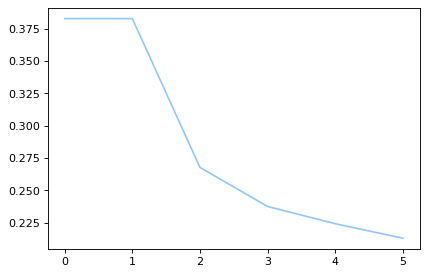

In [45]:
parameters['reload']=False

if not parameters['reload']:
    tr = time.time()
    model.train(True)
    for epoch in range(1,number_of_epochs):
        for i, index in enumerate(np.random.permutation(len(train_data))):
            count += 1
            data = train_data[index]

            ##gradient updates for each data entry
            model.zero_grad()

            network_in = data['readings']
            network_in = torch.Tensor(network_in)
            #network_in = torch.nn.functional.normalize(network_in, p=2.0, dim = 0)
            tags = data['tags']

            targets = torch.LongTensor(tags)

            #we calculate the negative log-likelihood for the predicted tags using the predefined function
            if use_gpu:
                neg_log_likelihood = model.neg_log_likelihood(network_in.cuda(), targets.cuda())
            else:
                neg_log_likelihood = model.neg_log_likelihood(network_in, targets)
            loss += neg_log_likelihood.item() / len(data['readings'])
            neg_log_likelihood.backward()

            #we use gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)
            optimizer.step()

            #Storing loss
            if count % plot_every == 0:
                loss /= plot_every
                print(count, ': ', loss)
                if losses == []:
                    losses.append(loss)
                losses.append(loss)
                loss = 0.0

            #Evaluating on Train, Test, Dev Sets
            if count % (eval_every) == 0 and count > (eval_every * 20) or \
                    count % (eval_every*4) == 0 and count < (eval_every * 20):
                model.train(False)
                best_train_F, new_train_F, _ = evaluating(model, train_data, best_train_F,"Train")
                best_dev_F, new_dev_F, save = evaluating(model, dev_data, best_dev_F,"Dev")
                if save:
                    print("Saving Model to ", model_name)
                    torch.save(model.state_dict(), model_name)
                #best_test_F, new_test_F, _ = evaluating(model, test_data, best_test_F,"Test")

                all_F.append([new_train_F, new_dev_F])
                model.train(True)

            #Performing decay on the learning rate
            if count % len(train_data) == 0:
                adjust_learning_rate(optimizer, lr=learning_rate/(1+decay_rate*count/len(train_data)))

    print(time.time() - tr)
    plt.plot(losses)
    plt.show()

# if not parameters['reload']:
#     #reload the best model saved from training
#     model.load_state_dict(torch.load(model_name))

### Model Testing

This is where we provide our readers with some fun, they can try out how the trained model functions on the sentences that you throw at it. Feel free to play around.


##### LIVE: PRODUCTION!

In [38]:
model_testing_sentences = ['Jay is from India','Donald is the president of USA']

#parameters
lower=parameters['lower']

#preprocessing
final_test_data = []
for sentence in model_testing_sentences:
    s=sentence.split()
    str_words = [w for w in s]
    words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>'] for w in str_words]
    
    # Skip characters that are not in the training set
    chars = [[char_to_id[c] for c in w if c in char_to_id] for w in str_words]
    
    final_test_data.append({
        'str_words': str_words,
        'words': words,
        'chars': chars,
    })

#prediction
predictions = []
print("Prediction:")
print("word : tag")
for data in final_test_data:
    words = data['str_words']
    chars2 = data['chars']

    d = {} 
    
    # Padding the each word to max word size of that sentence
    chars2_length = [len(c) for c in chars2]
    char_maxl = max(chars2_length)
    chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
    for i, c in enumerate(chars2):
        chars2_mask[i, :chars2_length[i]] = c
    chars2_mask = Variable(torch.LongTensor(chars2_mask))

    dwords = Variable(torch.LongTensor(data['words']))

    # We are getting the predicted output from our model
    if use_gpu:
        val,predicted_id = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
    else:
        val,predicted_id = model(dwords, chars2_mask, chars2_length, d)

    pred_chunks = get_chunks(predicted_id,tag_to_id)
    temp_list_tags=['NA']*len(words)
    for p in pred_chunks:
        temp_list_tags[p[1]]=p[0]
        
    for word,tag in zip(words,temp_list_tags):
        print(word,':',tag)
    print('\n')

Prediction:
word : tag
Jay : PER
is : NA
from : NA
India : LOC


Donald : PER
is : NA
the : NA
president : NA
of : NA
USA : LOC




### References

1) Xuezhe Ma and Eduard Hovy. 2016. ** End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF .** In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: LongPapers). Association for Computational Linguistics, Berlin, Germany ** (https://arxiv.org/pdf/1603.01354.pdf) **

2) Official PyTorch Tutorial : [** Advanced: Making Dynamic Decisions and the Bi-LSTM CRF **](http://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html#sphx-glr-beginner-nlp-advanced-tutorial-py)

3) [** Sequence Tagging with Tensorflow **](https://guillaumegenthial.github.io/sequence-tagging-with-tensorflow.html)  using bi-LSTM + CRF with character embeddings for NER and POS by Guillaume Genthial

4) Github Repository - [** Reference Github Repository **](https://github.com/jayavardhanr/End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial)
